In [97]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import re

In [82]:
df = pd.read_csv(SUMMARY_FILE)
df.head(2)

,date,exchange,q,ticker,transcript,call_datetime,quarter_only,transcript_clean_basic,transcript_nlp,prepared_remarks,qna,prepared_len,qna_len,prepared_summary,qna_summary,api_called
0,"Nov 17, 2022, 5:00 p.m. ET",NYSE: GPS,2022-Q3,GPS,"Prepared Remarks:\nOperator\nGood afternoon, l...",2022-11-17 17:00:00,Q3,"Prepared Remarks:\nOperator\nGood afternoon, l...","Good afternoon, ladies and gentlemen. My name ...","Prepared Remarks:\nOperator\nGood afternoon, l...",Questions & Answers:\nOperator\n[Operator inst...,23689,34247,- Performance: Gap Inc.'s third quarter 2022 n...,- Management indicated that they are prepared ...,True
1,"Feb 10, 2021, 5:00 p.m. ET",NASDAQ: QLYS,2020-Q4,QLYS,Prepared Remarks:\nOperator\nLadies and gentle...,2021-02-10 17:00:00,Q4,Prepared Remarks:\nOperator\nLadies and gentle...,I will now turn the conference over to Mr. Vin...,Prepared Remarks:\nOperator\nLadies and gentle...,Questions and Answers:\nOperator\nThank you. [...,20191,35689,- Performance: Revenues for Q4 2020 grew 12% t...,- Customers are looking for solutions to help ...,True


In [83]:
# shape and columns appear correct 
print(df.shape)
print("\nColumns:")
print(df.columns.tolist())


(497, 16)

Columns:
['date', 'exchange', 'q', 'ticker', 'transcript', 'call_datetime', 'quarter_only', 'transcript_clean_basic', 'transcript_nlp', 'prepared_remarks', 'qna', 'prepared_len', 'qna_len', 'prepared_summary', 'qna_summary', 'api_called']


In [85]:
# all rows contian a summary 
summary_cols = ["prepared_summary", "qna_summary"]
missing_summary_counts = df[summary_cols].isna().sum()
print("Missing summaries:")
print(missing_summary_counts)

Missing summaries:
prepared_summary    0
qna_summary         0
dtype: int64


In [88]:
for col in summary_cols:
    df[f"{col}_char_len"] = df[col].fillna("").str.len()

In [89]:
#character len seem is higher than expected for 4-6 bullet points
df[[f"{c}_char_len" for c in summary_cols]].describe()

,prepared_summary_char_len,qna_summary_char_len
count,497.000000,497.000000
mean,2571.881288,3039.539235
std,894.225604,1280.557963
min,466.000000,83.000000
25%,1911.000000,2105.000000
50%,2554.000000,3028.000000
75%,3116.000000,3906.000000
max,5226.000000,9025.000000


In [91]:
df["prepared_summary_word_count"] = (
    df["prepared_summary"].fillna("").str.split().str.len()
)

df["qna_summary_word_count"] = (
    df["qna_summary"].fillna("").str.split().str.len()
)


In [94]:
df.columns.to_list()

['date',
 'exchange',
 'q',
 'ticker',
 'transcript',
 'call_datetime',
 'quarter_only',
 'transcript_clean_basic',
 'transcript_nlp',
 'prepared_remarks',
 'qna',
 'prepared_len',
 'qna_len',
 'prepared_summary',
 'qna_summary',
 'api_called',
 'prepared_summary_char_len',
 'qna_summary_char_len',
 'prepared_summary_word_count',
 'qna_summary_word_count']

In [96]:
# many  summaries are too verbose based on the prompt 
df[[f"{c}_word_count" for c in summary_cols]].describe()

,prepared_summary_word_count,qna_summary_word_count
count,497.000000,497.000000
mean,383.388330,461.847082
std,132.361035,192.972265
min,63.000000,15.000000
25%,287.000000,325.000000
50%,375.000000,457.000000
75%,459.000000,591.000000
max,755.000000,1355.000000


In [100]:
def sentence_count(text):
    if not isinstance(text, str):
        return 0
    return len(re.findall(r"[.!?]+", text))

df["prepared_summary_sentence_count"] = df["prepared_summary"].apply(sentence_count)
df["qna_summary_sentence_count"] = df["qna_summary"].apply(sentence_count)


Appear to be lacking conciseness in the summaries. Over 40 'sentences' in some cases and some with 0 which based on other metrics may be a punctuation issue

In [128]:
df[[f"{c}_sentence_count" for c in summary_cols]].describe()

,prepared_summary_sentence_count,qna_summary_sentence_count
count,497.000000,497.000000
mean,18.680080,17.253521
std,8.511393,8.362027
min,0.000000,0.000000
25%,12.000000,11.000000
50%,18.000000,16.000000
75%,24.000000,22.000000
max,46.000000,50.000000


In [129]:
#cehcek is zero senteneces are missign summaries completely
zero_sentence = df[(df['prepared_summary_sentence_count'] == 0) | (df['qna_summary_sentence_count'] == 0)]

In [130]:
# zero sentence summaries likely missing punctuation
zero_sentence[['prepared_summary_sentence_count', 'prepared_summary_word_count', 'qna_summary_sentence_count',  'qna_summary_word_count']]

,prepared_summary_sentence_count,prepared_summary_word_count,qna_summary_sentence_count,qna_summary_word_count
1,12,172,0,102
6,0,251,6,155
14,14,197,0,80
55,0,88,20,663
123,0,251,30,655


In [49]:

def bullet_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip().lower()
        if line_clean.startswith("-"):
            count += 1
    return count


In [127]:
df["prepared_summary_bullet_count"] = df["prepared_summary"].apply(bullet_count)
df["qna_summary_bullet_count"] = df["qna_summary"].apply(bullet_count)

Prompt was for 4-6 bullet points per summary - will need to deduplicate or more precise prompts

In [131]:
df[[f"{c}_bullet_count" for c in summary_cols]].describe()

,prepared_summary_bullet_count,qna_summary_bullet_count
count,497.000000,497.000000
mean,16.060362,18.937626
std,7.458783,7.653413
min,4.000000,0.000000
25%,12.000000,14.000000
50%,14.000000,19.000000
75%,21.000000,24.000000
max,48.000000,55.000000


In [168]:
#prepared summary expectaion was the below sections
EXPECTED_SECTIONS = [
    "Performance",
    "Guidance",
    "Risks",
    "Strategic changes"
]

In [165]:
def section_header_count(text):
    if not isinstance(text, str):
        return 0

    count = 0
    for line in text.splitlines():
        line_clean = line.strip()
        for section in EXPECTED_SECTIONS:
            if (f"{section}") in line_clean:
                count += 1
    return count

In [166]:
df["prepared_summary_section_count"] = df["prepared_summary"].apply(section_header_count)

Appears it is repeating the sections multiple times in most prepared summaries

In [169]:
df['prepared_summary_section_count'].describe()

count    497.000000
mean       9.376258
std        3.749903
min        0.000000
25%        8.000000
50%        8.000000
75%       12.000000
max       24.000000
Name: prepared_summary_section_count, dtype: float64

Compression Ratio

In [170]:
def word_count(text):
    if not isinstance(text, str):
        return 0
    return len(text.split())

# word counts
df["prepared_word_count"] = df["prepared_remarks"].apply(word_count)
df["prepared_summary_word_count"] = df["prepared_summary"].apply(word_count)

# compression ratio (summary / original)
df["prepared_word_compression"] = (
    df["prepared_summary_word_count"] / df["prepared_word_count"]
)


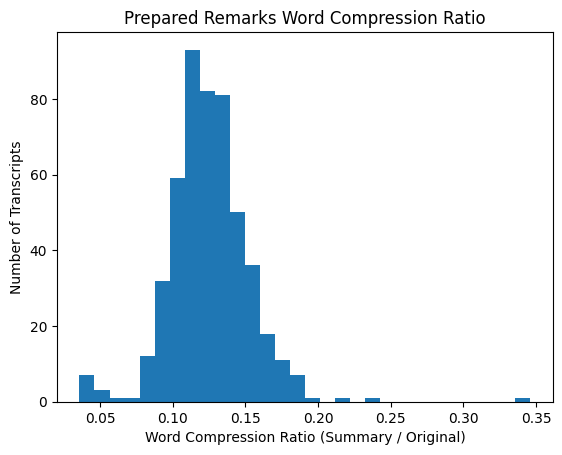

In [195]:
plt.figure()
plt.hist(df["prepared_word_compression"], bins=30)
plt.xlabel("Word Compression Ratio (Summary / Original)")
plt.ylabel("Number of Transcripts")
plt.title("Prepared Remarks Word Compression Ratio")
plt.show()

In [196]:
df["qna_word_count"] = df["qna"].apply(word_count)
df["qna_summary_word_count"] = df["qna_summary"].apply(word_count)

df["qna_word_compression"] = (
    df["qna_summary_word_count"] / df["qna_word_count"]
)

In [197]:
# outliers need to investigate
df['qna_word_compression'].describe()

count    497.000000
mean       0.105409
std        0.137698
min        0.001572
25%        0.088712
50%        0.096224
75%        0.105282
max        3.034483
Name: qna_word_compression, dtype: float64

In [199]:
# outliers in very short qna sections
outliers = df[df['qna_word_compression'] > .25]
outliers[['qna_word_count', 'qna_summary_word_count']]

,qna_word_count,qna_summary_word_count
257,29,88
484,61,54


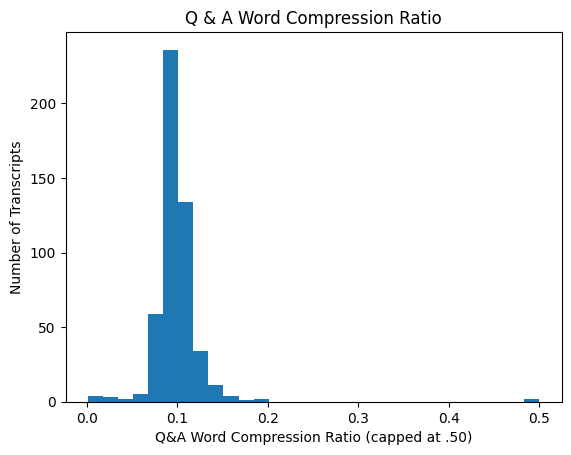

In [201]:
plt.figure()
plt.hist(df["qna_word_compression"].clip(upper=.50), bins=30) # remove outliers
plt.xlabel("Q&A Word Compression Ratio (capped at .50)")
plt.ylabel("Number of Transcripts")
plt.title("Q & A Word Compression Ratio")
plt.show()